## Read Data (replies already been excluded)

In [1]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
import pandas as pd

text = pd.read_csv('Jan6(excludes replies).csv')
print('The number of tweets (excludes replies) before data pre-processing:',len(text))

The number of tweets (excludes replies) before data pre-processing: 6501


## Data Pre-processing

In [2]:
import gensim
import gensim.corpora as corpora
import re
porter = PorterStemmer()
stop_words = stopwords.words('english')
b = []
for i,u in text.iterrows():
    a = []
    word =''
    for words in str(u['tweets']).split(): #tokenization
        if '@' not in words: #remove @users
            words = words.replace('#','') #remove hashtag symbol
            if '#' not in words:
                if 'http' not in words: #remove URLs
                    if'&amp' not in words: #remove symbol
                        words = re.sub(r'[^a-zA-Z]', ' ', words)
                        words = words.lower()# lower form
                        #words = re.sub(r'[^a-zA-Z]', ' ', words) #remove non-alphabetic characters
                        if len(words)>2:
                            word += (words+' ')
    doc = ''
    for token in word.split():
        if len(token) >2: # remove words that have less than 3 characters
            if token not in stop_words:# remove stopwords
                token = porter.stem(token) #stemming
                doc += (token+' ')
    b.append(doc)
text['processed']=[i for i in b]

# exclude tweets that are not in English
non_english_list = ['temiz','rkiy','erik','nda','konu','dan','da','ba','temiz','al','viand','para','na','dann','uft','laboratorio','dieser','kalbimi',
                   'restoranda','evento','komo','ind','tica','futuro','sonra','yla','cre','ili','daki',
                   'zaman']
index_axis = []
for index,i in text.iterrows():
    if len(i['processed']) == 0:
        index_axis.append(index)
    else:
        for word in i['processed'].split():
            if word in non_english_list:
                index_axis.append(index)
                break
text.drop(text.index[index_axis],inplace=True)
print("number of tweets after cleaning:",len(text))

number of tweets after cleaning: 6248


### Number of tweets from each company after pre-processing:

In [3]:
text.groupby('Company')['tweets'].count().sort_values(ascending=False)

Company
Memphis Meats       1545
biftek.co 🔬👩‍🔬🐄🥗    1429
Aleph Farms          704
Finless Foods        516
shiokmeats           463
SuperMeat            315
New Age Meats        306
BlueNalu             273
CUBIQ FOODS          243
Meatable             114
Mosa Meat            108
Wildtype              89
Future Fields         44
Vow                   36
FutureMeat            32
Balletic Foods        25
Mission Barns          2
LabFarmFoods           2
Avant Meats            2
Name: tweets, dtype: int64

## GuidedLDA

In [4]:
import guidedlda
import numpy as np
seed_topic_list = [['environ','carbon','greenhous','futur','emiss','better','planet','save','reduc',
                   'system','land','plastic','sustain','climat','environment','climatechang'], #0 Environmental Impact
                   ['plant','vegan','vegetarian','anim','altern','protein','plantbas'], #1 Vegetarian
                   ['without','harm','slaughter','cruelti','welfar','kill','cow','human','farm','save','free','anim'],#2 Animal Welfare
                   ['consumpt','popul','demand','secur','wast','grow','global','sustain','need',
                   'consum','eat','growth','feed','solut'],#3 Food Security
                   ['antibiot','antimicrobi','resist','safe','contamin','free','health','overus',
                   'diseas','use','metal','bacteria'],#4 Food Safety
                   ['regulatori','usda','fda','safe','joint','label'],#5 Regulations
                   ['covid','pandem','risk','coronaviru'],# 6 COVID-19 Pandemic
                   ['industri','suppli','convent','system','chain','compani',
                    'market','consum','store','groceri','product','demand','grow','launch','scale','cost','sell'],#7 Food Industry & Market
                   ['seafood','ocean','fish','aquacultur','shrimp','salmon','wild','lobster','tuna','sushi','crustacean'],#8 Seafood
                   ['chicken','duck','poultri','burger','steak','meatbal','beef','sausag',
                    'tast','tender','textur','juici','test','delici','culinari','favorit','tasti'],#9 Poultry and Meat
                   ['stem','muscl','divis','biolog','cellular','technolog','agricultur','creat','made','biotech','tech'],#10 Process
                   ['seri','fund','rais','invest','dollar','pound','round','startup',
                   'opportun','first','seed','isra','acceler','announc','happi','thrill','excit','pleas','contribut','honor','proud','statement'], #11 Fundraising Announcement
                   ['thank','support','shoutout','help','question','mention'], #12 Appreciation
                   ['confer','regist','live','symposium','stream','livestream','summit','founder','talk','speak','ceo'], #13 Conference and Summit
                   ['hire','join','team','bring','welcom','work','appli','research','specialist','student','career','posit'],#14 Hiring Information
                   ['congrat','congratul','list','award','winner','finalist','partner','prize'],#15 Congratulations
                   ['check','post','paper','interview','articl','blog','news','break','read',
                   'latest','watch','podcast','listen','episod','stori','coverag','campaign','video','discuss',
                    'chat','report','ceo','media','present']]#16 Media

from sklearn.feature_extraction.text import CountVectorizer
model = guidedlda.GuidedLDA(n_topics=19,n_iter=1000,random_state=1,refresh=10,alpha=0.01,eta=0.01)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text['processed'])

vocab = vectorizer.get_feature_names()
word2id = dict((v,idx) for idx,v in enumerate(vocab))
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

model.fit(X.toarray(),seed_topics=seed_topics,seed_confidence=0.7) #set seed confidence to 0.7
topic_word = model.topic_word_
n_top_words = 30
vocab = tuple(vocab)

for i, topic_dist in enumerate(topic_word): #Print out results
    print('\n')
    print('Topic:',i)
    words_probability = np.array(-topic_dist)
    for index in range(n_top_words):
        print(round(abs(np.sort(words_probability))[:(n_top_words)][index],4),'*',
              np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1][index],sep='',end='  ')
        

INFO:guidedlda:n_documents: 6248
INFO:guidedlda:vocab_size: 7520
INFO:guidedlda:n_words: 74569
INFO:guidedlda:n_topics: 19
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -987298
INFO:guidedlda:<10> log likelihood: -619882
INFO:guidedlda:<20> log likelihood: -605377
INFO:guidedlda:<30> log likelihood: -598373
INFO:guidedlda:<40> log likelihood: -594078
INFO:guidedlda:<50> log likelihood: -591935
INFO:guidedlda:<60> log likelihood: -590136
INFO:guidedlda:<70> log likelihood: -588420
INFO:guidedlda:<80> log likelihood: -587637
INFO:guidedlda:<90> log likelihood: -586575
INFO:guidedlda:<100> log likelihood: -586189
INFO:guidedlda:<110> log likelihood: -585118
INFO:guidedlda:<120> log likelihood: -584952
INFO:guidedlda:<130> log likelihood: -584277
INFO:guidedlda:<140> log likelihood: -583881
INFO:guidedlda:<150> log likelihood: -583686
INFO:guidedlda:<160> log likelihood: -583559
INFO:guidedlda:<170> log likelihood: -582938
INFO:guidedlda:<180> log likelihood: -582422
INFO:



Topic: 0
0.0404*meat  0.0314*chang  0.0251*food  0.0224*climat  0.0184*anim  0.013*world  0.0121*impact  0.0114*eat  0.0101*sustain  0.0094*planet  0.009*environment  0.009*reduc  0.0088*could  0.0083*one  0.0081*use  0.0079*environ  0.0076*futur  0.0074*help  0.0074*peopl  0.0072*product  0.0067*less  0.0065*better  0.0065*emiss  0.0063*way  0.0063*need  0.0061*water  0.0061*land  0.0061*potenti  0.0058*system  0.0056*would  

Topic: 1
0.0381*meat  0.0284*plant  0.028*base  0.02*protein  0.0188*industri  0.0165*food  0.0162*market  0.0146*plantbas  0.0134*burger  0.012*year  0.0118*altern  0.0115*vegan  0.0094*new  0.0082*global  0.0078*compani  0.0073*beyond  0.0073*invest  0.0071*foodtech  0.0066*sale  0.0063*first  0.0061*product  0.0059*could  0.0059*billion  0.0056*demand  0.0056*via  0.0054*next  0.0052*see  0.0052*launch  0.0052*top  0.0049*growth  

Topic: 2
0.0996*meat  0.0544*anim  0.0282*without  0.0184*make  0.0176*clean  0.0151*cleanmeat  0.0151*futur  0.0149*real  0.01

## Categorize Tweets according to their most salient topic

In [5]:
doc_topic = model.transform(X)
topic_number = []
number = []

for i in range(len(doc_topic)):
    topic_number.append(doc_topic[i].argmax())
    number.append('1')
data = pd.DataFrame(data=[i for i in topic_number],columns=['topic_number'])
data['number'] = [i for i in number]
number_of_tweets = pd.DataFrame(data.groupby('topic_number')['number'].count())
number_of_tweets['proportion'] = [str(round(i/len(text)*100,2))+'%' for i in number_of_tweets['number']]
number_of_tweets

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


,number,proportion
topic_number,,
0,341,5.46%
1,348,5.57%
2,494,7.91%
3,315,5.04%
4,217,3.47%
5,251,4.02%
6,143,2.29%
7,360,5.76%
8,192,3.07%


## Prominent factor

In [6]:
prominent_factor = []
for i in range(len(doc_topic)):
    prominent_factor.append(sorted(doc_topic[i])[-1]/sorted(doc_topic[i])[-2])
count = 0
for i in prominent_factor:
    if i >= 1.4:
        count += 1
print('There are ',round(count/len(text)*100,2),'% of tweets with prominent factor higher or equal to 1.4',sep='',)

There are 79.95% of tweets with prominent factor higher or equal to 1.4


## Topic-Author Analysis

In [7]:
doc_topic = model.transform(X)
topic_number1 = []


for i in range(len(doc_topic)):
    topic_number1.append(doc_topic[i].argmax())
text['topic number'] = [i for i in topic_number1]
topic_author = text.groupby(['topic number','Company'])['tweets'].count()
topic_author_3d = topic_author.unstack()
topic_author_3d = topic_author_3d[['Memphis Meats','biftek.co 🔬👩‍🔬🐄🥗','Aleph Farms','SuperMeat',
                                  'Finless Foods','shiokmeats','BlueNalu','New Age Meats','CUBIQ FOODS',
                                  'Mosa Meat','Wildtype','Meatable','Future Fields','Vow',
                                  'FutureMeat','Balletic Foods','LabFarmFoods','Avant Meats','Mission Barns']]

topic = ['Environmental Impact','Vegetarian and Alternative Protein','Animal Welfare',
        'Food Security', 'Food Safety', 'Regulations','COVID-19 Pandemic','Food Industry and Market',
         'Seafood','Poultry and Meat','Process','Announcement(fundraising)',
        'Appreciation','Conference and Summit','Hiring Informaiton','Congratulations',
        'Media','Unseeded Topic 1','Unseeded Topic 2']

company = ['Memphis Meats','Biftek.co','Aleph Farms','SuperMeat','Fineless Foods','Shiok Meats','BlueNalu',
          'New Age Meats','Cubiq Foods','Mosa Meat','Wild Type','Meatable','Future Fields','Vow','Future Meat',
           'Balletic Foods','Lab Farm Foods','Avant Meats','Mission Barns']

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


## Heatmap based on proportion of each topic for each company

In [8]:
topic_author_3d = topic_author_3d.fillna(0) #replace NaN by 0

In [9]:
topic_author_3d.div(topic_author_3d.sum(axis=0),axis=1)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Company,Memphis Meats,biftek.co 🔬👩‍🔬🐄🥗,Aleph Farms,SuperMeat,Finless Foods,shiokmeats,BlueNalu,New Age Meats,CUBIQ FOODS,Mosa Meat,Wildtype,Meatable,Future Fields,Vow,FutureMeat,Balletic Foods,LabFarmFoods,Avant Meats,Mission Barns
topic number,,,,,,,,,,,,,,,,,,,
0,0.053074,0.067180,0.061080,0.120635,0.052326,0.017279,0.029304,0.016340,0.065844,0.064815,0.033708,0.043860,0.022727,0.000000,0.06250,0.00,0.0,0.0,0.0
1,0.025243,0.127362,0.026989,0.015873,0.032946,0.041037,0.025641,0.016340,0.156379,0.046296,0.000000,0.035088,0.000000,0.027778,0.12500,0.12,0.0,0.0,0.0
2,0.137864,0.055983,0.029830,0.352381,0.027132,0.012959,0.007326,0.062092,0.032922,0.009259,0.033708,0.096491,0.000000,0.027778,0.06250,0.04,0.5,0.0,0.0
3,0.036246,0.027292,0.058239,0.047619,0.081395,0.030238,0.234432,0.029412,0.069959,0.027778,0.067416,0.035088,0.022727,0.027778,0.00000,0.12,0.0,0.0,0.0
4,0.016181,0.079776,0.011364,0.031746,0.031008,0.036717,0.014652,0.039216,0.037037,0.000000,0.011236,0.008772,0.000000,0.000000,0.00000,0.00,0.0,0.0,0.0
5,0.057605,0.018894,0.024148,0.019048,0.050388,0.015119,0.043956,0.160131,0.016461,0.027778,0.033708,0.026316,0.000000,0.083333,0.00000,0.08,0.0,0.0,0.0
6,0.016828,0.030791,0.025568,0.019048,0.032946,0.012959,0.003663,0.016340,0.020576,0.046296,0.011236,0.061404,0.022727,0.000000,0.03125,0.00,0.0,0.0,0.0
7,0.026537,0.111966,0.051136,0.019048,0.052326,0.056156,0.051282,0.042484,0.065844,0.055556,0.033708,0.035088,0.000000,0.055556,0.12500,0.04,0.0,0.5,0.0
8,0.007767,0.017495,0.004261,0.003175,0.118217,0.032397,0.131868,0.013072,0.004115,0.009259,0.359551,0.008772,0.000000,0.000000,0.00000,0.00,0.0,0.0,0.0


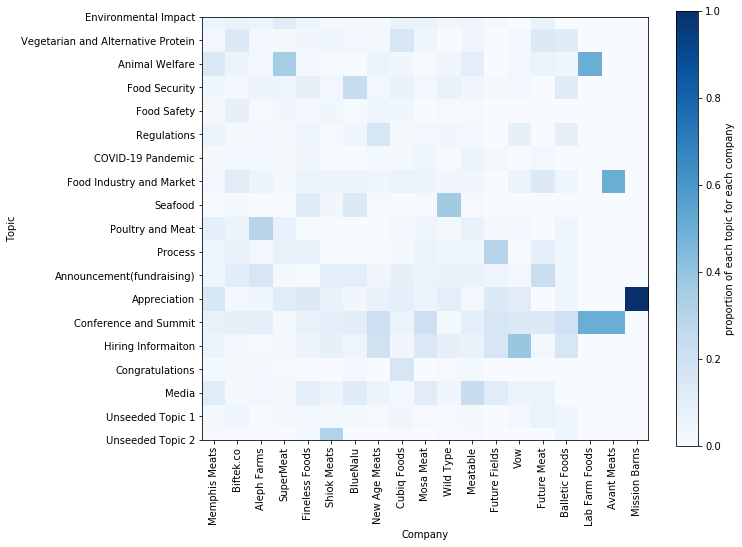

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.imshow(topic_author_3d.div(topic_author_3d.sum(axis=0),axis=1),cmap="Blues")
plt.colorbar().ax.set_ylabel('proportion of each topic for each company')
plt.xticks(range(len(topic_author_3d)), company,rotation=90)
plt.yticks(range(len(topic_author_3d)), topic)
plt.xlabel('Company')
plt.ylabel('Topic')
plt.show()

## PyLDAvis Visualization

In [13]:
import pyLDAvis
import pyLDAvis.sklearn
data = pyLDAvis.sklearn.prepare(model, X, vectorizer)

pyLDAvis.display(data)

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### This visualization seems not to match the results in guidedLDA. The index of topics in this visualization was different from the index of the topics in guidedLDA.
